# Single trace FWI sensitivity kernel
Here we generate a single source, single receiver "banana donut" sensitivity kernel for full waveform inversion in constant velocity models. The workflow:
1. generate forward modeled data in true model
1. generate forward modeled data in slow model
1. backproject the residual (d_true - d_slow) ... the fwi gradient

In [1]:
using PyPlot, Jets, WaveFD, JetPackWaveFD, Random

## Generate the true and starting models

In [2]:
nz,nx = 400,600
dz,dx = 20.0,20.0
@show nz,nx;
@show dz,dx
v1 = 2000 .* ones(nz,nx)
v2 = 1950 .* ones(nz,nx);

(nz, nx) = (400, 600)
(dz, dx) = (20.0, 20.0)


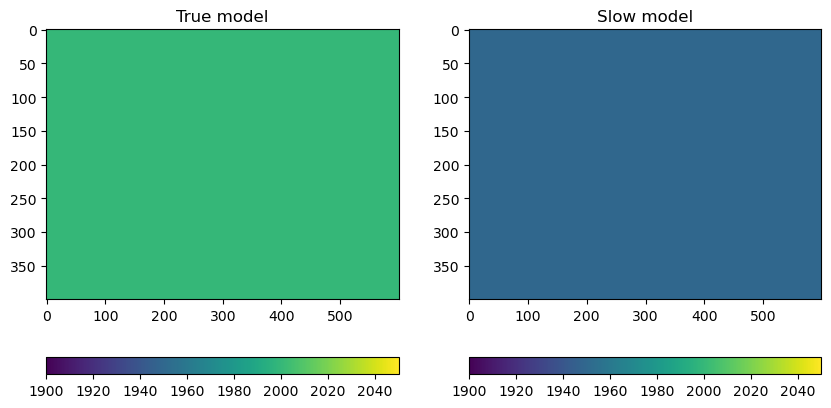

extrema(v1) = (2000.0, 2000.0)


In [3]:
figure(figsize=(10,5))
vmin,vmax = 1900,2050
@show extrema(v1)
subplot(121);imshow(v1,aspect="auto");title("True model");clim(vmin,vmax);
colorbar(orientation="horizontal")
subplot(122);imshow(v2,aspect="auto");title("Slow model");clim(vmin,vmax)
colorbar(orientation="horizontal");

## Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [4]:
scratch = "/mnt/scratch"
@assert isdir(scratch)

In [5]:
F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
    b = ones(Float32,size(v1)),
    nthreads = Sys.CPU_THREADS,
    isinterior = true,
    nsponge = 80,
    ntrec = 2001,
    dtrec = 0.004,
    dtmod = 0.002,
    dz = dz,
    dx = dx,
    wavelet = WaveletCausalRicker(f=2.5),
    sx = dx * (1),
    sz = dz * div(nz,2),
    rx = [dx * (nx-1)],
    rz = [dz * div(nz,2)],
    srcfieldfile = joinpath(scratch, "field-$(randstring()).bin"),
    reportinterval=1000);

## Forward modeling in true and slow models

In [6]:
d1 = F*v1;
d2 = F*v2;

┌ Info: nonlinear forward on cbox-wask-HB60rs, srcfieldfile=/mnt/scratch/field-kja5nRqP.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:387
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  4001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  4001 ;  168.66 MCells/s (IO=55.46%, EX=26.09%) -- rms d,p; 0.0000e+00 1.6118e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  4001 ;  191.23 MCells/s (IO=59.09%, EX=23.65%) -- rms d,p; 0.0000e+00 7.6385e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time 

## Compute the residual
With $v_1$ the true model, and $v_2$ the background model, the FWI objective function is written as:

$$
\bigl\| f(v_2) - f(v_1) \bigr\|
$$

The residual is then: 

$$
r = d_2 - d_1
$$

In [7]:
r = d2 .- d1
@show extrema(d1)
@show extrema(d2)
@show extrema(r)

extrema(d1) = (-1.9544239f0, 3.1496422f0)
extrema(d2) = (-1.8844594f0, 3.0342908f0)
extrema(r) = (-5.0061893f0, 3.5186372f0)


(-5.0061893f0, 3.5186372f0)

## Plot the generated traces

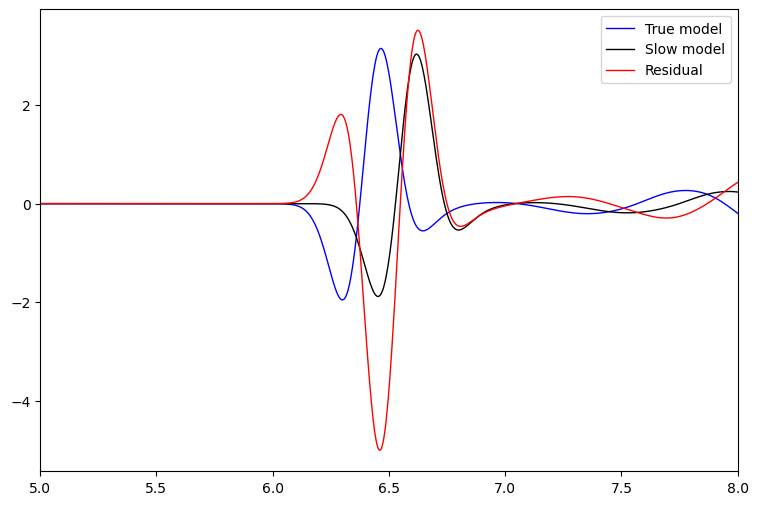

In [8]:
dmax = maximum(abs, d1)
figure(figsize=(9,6)); clf()
t = 0.004 .* [0:1:2000;]
plot(t,d1[:], label="True model", "blue", linewidth=1)
plot(t,d2[:], label="Slow model", "black", linewidth=1)
plot(t,r[:], label="Residual", "red", linewidth=1)
xlim(5,8)
legend()
nothing

## Backproject the residual with the Jacobian adjoint

In [9]:
J = jacobian(F, v2)
dv = J' * r;

┌ Info: nonlinear forward on cbox-wask-HB60rs, srcfieldfile=/mnt/scratch/field-kja5nRqP.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:387
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  4001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  4001 ;  127.75 MCells/s (IO=38.44%, EX=31.47%) -- rms d,p; 0.0000e+00 1.5720e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  4001 ;  151.77 MCells/s (IO=45.57%, EX=28.73%) -- rms d,p; 0.0000e+00 7.5565e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time 

## Plot the sensitivity kernel
Note this is the FWI gradient, and we would improve the velocity model by `-1 * gradient`. The blue central part of the sensitivity kernel therefore has the correct polarity, indicating we need to make the slow velocity model faster.

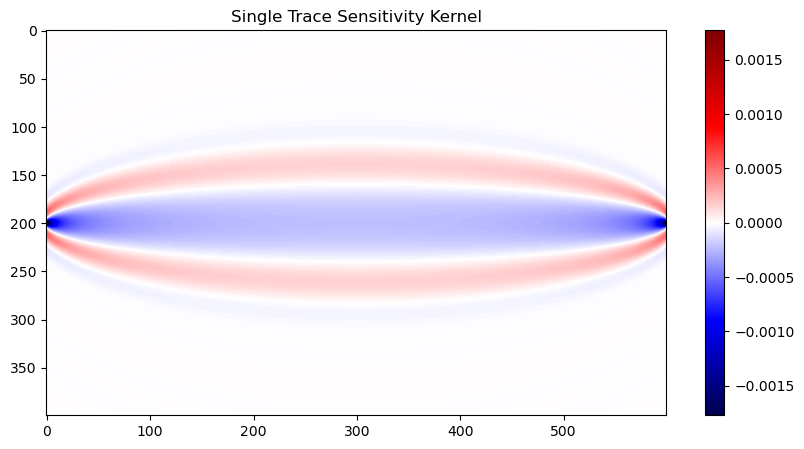

In [10]:
figure(figsize=(10,5))
dmax = maximum(abs,dv)
imshow(dv,aspect="auto", cmap="seismic", clim=0.5 .* [-dmax,dmax]);
title("Single Trace Sensitivity Kernel")
colorbar();